# Naive Bayes Algorithm Implementation

In this project, I am going to explore two different datasets. One dataset is from kaggle and has data about the passengers from the titanic, and whether they survived or not. The other dataset was pulled from UCI's website, which includes data about patients and whether they had cancer or not. We are going to explore the regular version of the naive bayes theorem and the algorithm with smoothing included. We will also try to feature engineer some of our features, determining whether it had a positive or negative effect on the model. The point of this project isn't to try and get the highest accuracy possible by overfitting to the data, but it is to really analyze the datasets and the assumptions made under the data. We are also going to see if in these cases, naive bayes algorithm is actually a good model or not. Let's get started :)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

## Titanic Dataset

First, we load in the dataset as a dataframe

In [2]:
titanic = pd.read_csv('train.csv')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Feature Selection

When deciding what features we use, we need to decide what features have meaning to us. I go into each feature below.

## PassengerId

This is simply to uniquely identify each passenger. It has no effect on the predictions.

## Survived
This feature is either '0' or '1', with '0' indicating the passenger died, and '1' indicating that the passenger survived.

## Ticket Class (Pclass)
Here we compute the survival rate (sr) for each of the three different class structures for people on board.

<AxesSubplot:xlabel='Sex'>

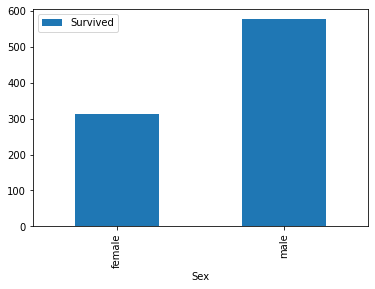

In [3]:
titanic.groupby('Sex').count().reset_index().plot(x='Sex', y='Survived', kind='bar')

In [4]:
upper_class_sr = len(titanic[(titanic['Pclass'] == 1) & (titanic['Survived'] == 1)]) / len(titanic[titanic['Pclass'] == 1])
middle_class_sr = len(titanic[(titanic['Pclass'] == 2) & (titanic['Survived'] == 1)]) / len(titanic[titanic['Pclass'] == 2])
lower_class_sr = len(titanic[(titanic['Pclass'] == 3) & (titanic['Survived'] == 1)]) / len(titanic[titanic['Pclass'] == 3])
upper_class_sr,middle_class_sr,lower_class_sr

(0.6296296296296297, 0.47282608695652173, 0.24236252545824846)

As we can see, the survival rate of higher class individuals are higher than those of lower class than them, and the survival rate rate of middle class individuals are higher than those lower class than them.

Thus, I think it is safe to say, that ticket class (Pclass) plays an important role in predicting survival.

## Sex

Similarly, we can see a huge difference in survial rates below between females and males among the titanic, making it important indicator on whether an individual survived.

In [5]:
female_sr = len(titanic[(titanic['Survived'] == 1) & (titanic['Sex'] == 'female')]) / len(titanic[titanic['Sex'] == 'female'])
male_sr = len(titanic[(titanic['Survived'] == 1) & (titanic['Sex'] == 'male')]) / len(titanic[titanic['Sex'] == 'male'])
female_sr, male_sr

(0.7420382165605095, 0.18890814558058924)

## Age

Here is the minimum, maximum, and mean age of the test dataset. A decimal age represents the age in months of an infant.

In [6]:
titanic['Age'].min(), titanic['Age'].max(), titanic['Age'].mean()

(0.42, 80.0, 29.69911764705882)

This is the distribution of the ages

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

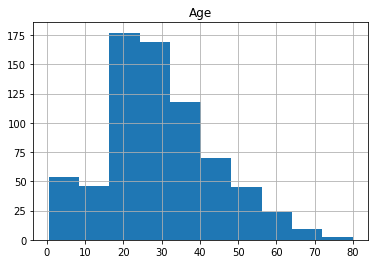

In [7]:
titanic.hist('Age')

We could either leave age in its original form or we can manipulate it (feature engineering) to group each age into certain groups. We will implement a function that manipulates the age column and apply it to our dataset later.

In [8]:
def create_age_groups(age):
    num_groups = 5
    return age // num_groups

## SibSp
This is the number of siblings and spouses. Siblings are defined as brothers, sisters, stepbrothers, stepsisters. Spouses are wifes and husbands (mistresses and fiances were ignored).

In [9]:
titanic[titanic['Survived'] == 1].groupby('SibSp').count()['Survived'] / titanic.groupby('SibSp').count()['Survived']

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5         NaN
8         NaN
Name: Survived, dtype: float64

We can see the proportion was higher for passengers that had less siblings and spouses. This could be because they didn't have to worry about other peoples' safety and could focus on their own during evacuation. We can play with this feature when we make our predictions.

## Parch
This is the number of parents and children this passenger has on the ship. A parent is defined as a mother or father, and a child can be defined as a daugther, son, stepdaughter, and stepson.

In [10]:
titanic[titanic['Survived'] == 1].groupby('Parch').count()['Survived'] / titanic.groupby('Parch').count()['Survived']

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4         NaN
5    0.200000
6         NaN
Name: Survived, dtype: float64

There is not really a strong relationship with the way having more parents and children affect your survival, but we can see that lower than 3 parents and siblings tend to have the most surival. This could be the same reason as for siblings and spouses where they didn't have to worry much about much people when evacuating.

## Ticket
We can see that compared to the length of the dataset, there are many unique tickets. Since tickets are so unique, tickets might not be such a good feature for predictor because it has nothing to do with survival.

In [11]:
len(titanic.groupby('Ticket').count())

681

## Fare
The fare is how much each passenger paid to get on the titanic. Typically, higher class passengers paid for better tickets while lower class tickets paid little at all. The fare most likely has a big impact on prediction because those who paid higher prices probably were treated better during evacuation.

The minimum, maximum, and mean fare is shown below

In [12]:
titanic['Fare'].min(), titanic['Fare'].max(), titanic['Fare'].mean()

(0.0, 512.3292, 32.204207968574636)

Here we see the distribution of the fare. The orange represents those who survived. We can see the proportion of those who survived is larger as the fare price increases.

(<AxesSubplot:>, <AxesSubplot:>)

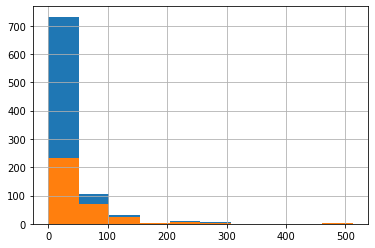

In [13]:
titanic['Fare'].hist(), titanic[titanic['Survived'] == 1]['Fare'].hist()

We can use various techniques to manipulate the fare so that we can better predict survival rate. Below I employ a simple technique which takes the midpoint between the lower class and middle class mean fare and the middle class and upper class mean fare.

In [14]:
first_second_mid = (titanic[titanic['Pclass'] == 3]['Fare'].mean() + titanic[titanic['Pclass'] == 2]['Fare'].mean()) / 2
second_third_mid = (titanic[titanic['Pclass'] == 1]['Fare'].mean() + titanic[titanic['Pclass'] == 2]['Fare'].mean()) / 2
first_second_mid, second_third_mid

(17.168866627003453, 52.40843532608695)

In [15]:
def create_fare_groups(fare):
    if fare <= first_second_mid:
        return 0
    elif fare <= second_third_mid:
        return 1
    else:
        return 2

## Cabin
If we look at the number of missing data for each feature, we can see that 'Cabin' has the majority of its data missing. Even if cabin was a good feature to predict survival, we don't really have the data for it unfortunately.

In [16]:
null_titanic = titanic.isna()
features = titanic.columns
for feature in features:
    total_count = len(titanic[feature])
    missing_count = len(null_titanic[null_titanic[feature] == True][feature])
    print("Feature: {0} , Total: {2}, Missing: {1}".format(feature, missing_count, total_count))

Feature: PassengerId , Total: 891, Missing: 0
Feature: Survived , Total: 891, Missing: 0
Feature: Pclass , Total: 891, Missing: 0
Feature: Name , Total: 891, Missing: 0
Feature: Sex , Total: 891, Missing: 0
Feature: Age , Total: 891, Missing: 177
Feature: SibSp , Total: 891, Missing: 0
Feature: Parch , Total: 891, Missing: 0
Feature: Ticket , Total: 891, Missing: 0
Feature: Fare , Total: 891, Missing: 0
Feature: Cabin , Total: 891, Missing: 687
Feature: Embarked , Total: 891, Missing: 2


## Embarked

Let's see if from where a passenger embarked has an effect on survival rate.
Ports of Embarkement:
Cherbourg = C
Queenstown = Q
Southampton = S

(0.33695652173913043, 0.5535714285714286, 0.38961038961038963)

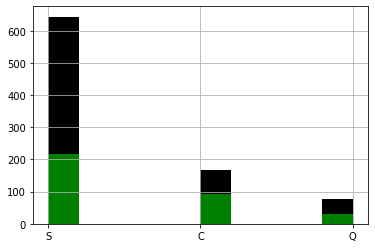

In [17]:
titanic['Embarked'].hist(color='black')
titanic[titanic['Survived'] == 1]['Embarked'].hist(color='green')
cherbourg = len(titanic[(titanic['Survived'] == 1) & (titanic['Embarked'] == 'C')]) / len(titanic[titanic['Embarked'] == 'C'])
queenstown = len(titanic[(titanic['Survived'] == 1) & (titanic['Embarked'] == 'Q')]) / len(titanic[titanic['Embarked'] == 'Q'])
southampton = len(titanic[(titanic['Survived'] == 1) & (titanic['Embarked'] == 'S')]) / len(titanic[titanic['Embarked'] == 'S'])
southampton, cherbourg, queenstown

We can see survival is varied amongst the ports of embarkment. So we can say this is a reasonable feature to use, however, we should consider whether this will actually help us find a good prediction. How would port of embarkment affect survival? Maybe how cabins were assigned based off which port you embarked from can be the case. We will mess around with this feature later.

## The Algorithm
I have implemented the naive bayes algorithm without smoothing and with smoothing

### No Smoothing

In [18]:
def compute_naive_bayes(data):
    passengers = len(titanic)
    survived = len(titanic[titanic['Survived'] == 1])
    died = len(titanic[titanic['Survived'] == 0])
    p_survived = survived / passengers
    p_died = died / passengers

    p_survived_features = p_survived
    p_died_features = p_died

    for i in range(len(features)):
        feature_count_survived = len(titanic[(titanic['Survived'] == 1) & (titanic[features[i]] == data[i])])
        feature_count_died = len(titanic[(titanic['Survived'] == 0) & (titanic[features[i]] == data[i])])
        p_feature_survived = feature_count_survived / survived
        p_feature_died = feature_count_died / died
        p_survived_features *= p_feature_survived
        p_died_features *= p_feature_died

        
    if p_survived_features > p_died_features:
        return 1
    else:
        return 0


### Smoothing

In [19]:
def compute_smooth_naive_bayes(data):
    passengers = len(titanic)
    survived = len(titanic[titanic['Survived'] == 1])
    died = len(titanic[titanic['Survived'] == 0])
    p_survived = survived / passengers
    p_died = died / passengers

    p_survived_features = p_survived
    p_died_features = p_died

    for i in range(len(features)):
        feature_count_survived = len(titanic[(titanic['Survived'] == 1) & (titanic[features[i]] == data[i])])
        feature_count_died = len(titanic[(titanic['Survived'] == 0) & (titanic[features[i]] == data[i])])
        p_feature_survived = (feature_count_survived + 1)  / (survived + len(titanic.groupby(features[i]).count()))
        p_feature_died = (feature_count_died + 1) / (died + len(titanic.groupby(features[i]).count()))
        p_survived_features *= p_feature_survived
        p_died_features *= p_feature_died

        
    if p_survived_features > p_died_features:
        return 1
    else:
        return 0


## Making Predictions
Once we have figured out what features to use and in what ways we can manipulate them, we can use our naive bayes algorithm we have computed on our test data to predict accuracy.

First let's read in our test data

In [20]:
test_titanic = pd.read_csv('test.csv')

We need to partition some of our train data to be our validation data. Here we do a 65% train, 35% validation split.

In [21]:
train_titanic, validate_titanic = \
              np.split(titanic.sample(frac=1, random_state=36), 
                       [int(.65*len(titanic))])
len(train_titanic), len(validate_titanic)

(579, 312)

## Validation and Accuracy

Here we define the features we want to use for our prediction and our validation accuracy

In [22]:
def compute_accuracy(features):
    validate_titanic['Prediction'] = validate_titanic.get(features).apply(compute_naive_bayes, axis=1)
    validate_accuracy = len(validate_titanic[validate_titanic['Survived'] == validate_titanic['Prediction']]) / len(validate_titanic)
    return validate_accuracy

In [23]:
def compute_accuracy_smoothing(features):
    validate_titanic['Prediction'] = validate_titanic.get(features).apply(compute_smooth_naive_bayes, axis=1)
    validate_accuracy = len(validate_titanic[validate_titanic['Survived'] == validate_titanic['Prediction']]) / len(validate_titanic)
    return validate_accuracy

In [24]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked']
compute_accuracy(features), compute_accuracy_smoothing(features)

(0.8269230769230769, 0.8525641025641025)

We can see that the smoothing technique yielded better results with our validation data.

## Preparing Results for Kaggle
Below we mimic what we did above but put our predictions for the test file to see our test accuracy. Let's do it.

In [25]:
test_titanic['Survived'] = test_titanic.get(features).apply(compute_smooth_naive_bayes, axis=1)

In [26]:
predictions = test_titanic[['PassengerId', 'Survived']]
predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [27]:
predictions.to_csv("predictions.csv")

Our test prediction accuracy was 74.6125 %

## Assessment
We see that we did pretty good with the naive bayes algorithm. Despite being able to optimize this algorithm some more with feature engineeering, I think it is not worth spending time on doing that because realistically, these titanic passengers were in a time of chaos when the ship was sinking. Thus, with all this noise, it is impossible to perfectly predict every passenger because there are many exceptions. We should acknowledge this. In the next segment, we study a dataset that should not contain too much noise compared to this dataset. Let's move on!

# Naive Bayes on Cancer Dataset

We know that the titanic was a time of chaos onboard, making it difficult to predict outcomes based on an algorithm. Thus, let's explore the efficiency of our naive bayes algorithm on a cancer dataset downloaded from UCI's extensive collection of datasets.

Here we read our cancer.data file with pandas

In [28]:
cells = pd.read_csv("breast-cancer.data")
cells

,Class,Age,Menopause,TumorSize,InvNodes,NodeCaps,DegMalig,Breast,BreastQuad,Irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


Lets analyze how many of no recurrence (cancer not detectable) and recurrence events (cancer detectable) there are. 

In [29]:
recurrence = len(cells[cells['Class'] == 'recurrence-events'])
no_recurrence = len(cells[cells['Class'] == 'no-recurrence-events'])
recurrence,no_recurrence

(85, 201)

We can see there is not much data compared to the titanic dataset. We are not going to spend too much time on looking at the features and will be getting right to the predictions.

## Splitting Data

In [30]:
train, validate, test = \
              np.split(cells.sample(frac=1, random_state=36), 
                       [int(.75*len(cells)), int(.875*len(cells))])
len(train), len(validate), len(test)

(214, 36, 36)

## Same Algorithm, Different Data

In [31]:
def compute_naive_bayes(data):
    size = len(cells)
    cancer = len(cells[cells['Class'] == 'recurrence-events'])
    benign = len(cells[cells['Class'] == 'no-recurrence-events'])
    p_cancer = cancer / size
    p_benign = benign / size

    p_cancer_features = p_cancer
    p_benign_features = p_benign

    for i in range(len(features)):
        feature_count_cancer = len(cells[(cells['Class'] == 'recurrence-events') & (cells[features[i]] == data[i])])
        feature_count_benign = len(cells[(cells['Class'] == 'no-recurrence-events') & (cells[features[i]] == data[i])])
        p_feature_cancer = (feature_count_cancer)  / (cancer)
        p_feature_benign = (feature_count_benign) / (benign)
        p_cancer_features *= p_feature_cancer
        p_benign_features *= p_feature_benign

        
    if p_cancer_features > p_benign_features:
        return 'recurrence-events'
    else:
        return 'no-recurrence-events'


In [32]:
def compute_smooth_naive_bayes(data):
    size = len(cells)
    cancer = len(cells[cells['Class'] == 'recurrence-events'])
    benign = len(cells[cells['Class'] == 'no-recurrence-events'])
    p_cancer = cancer / size
    p_benign = benign / size

    p_cancer_features = p_cancer
    p_benign_features = p_benign

    for i in range(len(features)):
        feature_count_cancer = len(cells[(cells['Class'] == 'recurrence-events') & (cells[features[i]] == data[i])])
        feature_count_benign = len(cells[(cells['Class'] == 'no-recurrence-events') & (cells[features[i]] == data[i])])
        p_feature_cancer = (feature_count_cancer + 1)  / (cancer + len(cells.groupby(features[i]).count()))
        p_feature_benign = (feature_count_benign + 1) / (benign + len(cells.groupby(features[i]).count()))
        p_cancer_features *= p_feature_cancer
        p_benign_features *= p_feature_benign

        
    if p_cancer_features > p_benign_features:
        return 'recurrence-events'
    else:
        return 'no-recurrence-events'


## Predictions

In [33]:
features = ['Age', 'Menopause', 'TumorSize', 'InvNodes', 'NodeCaps', 'DegMalig', 'Breast', 'BreastQuad','Irradiat']

In [34]:
validate['Prediction'] = validate.get(['Age', 'Menopause', 'TumorSize', 'InvNodes', 'NodeCaps', 'DegMalig', 'Breast', 'BreastQuad','Irradiat']).apply(compute_smooth_naive_bayes, axis=1)
accuracy = len(validate[validate['Class'] == validate['Prediction']]) / len(validate)
accuracy

0.8055555555555556

In [35]:
test['Prediction'] = test.get(['Age', 'Menopause', 'TumorSize', 'InvNodes', 'NodeCaps', 'DegMalig', 'Breast', 'BreastQuad','Irradiat']).apply(compute_smooth_naive_bayes, axis=1)
accuracy_test = len(test[test['Class'] == test['Prediction']]) / len(test)
accuracy_test

0.6666666666666666

## Sample Size Matters
Here we rerun the predictions but split the data into train, validate, and test with a different random state.

In [36]:
train, validate, test = \
              np.split(cells.sample(frac=1, random_state=65), 
                       [int(.75*len(cells)), int(.875*len(cells))])
len(train), len(validate), len(test)

(214, 36, 36)

In [37]:
validate['Prediction'] = validate.get(['Age', 'Menopause', 'TumorSize', 'InvNodes', 'NodeCaps', 'DegMalig', 'Breast', 'BreastQuad','Irradiat']).apply(compute_smooth_naive_bayes, axis=1)
accuracy = len(validate[validate['Class'] == validate['Prediction']]) / len(validate)
accuracy

0.6666666666666666

In [38]:
test['Prediction'] = test.get(['Age', 'Menopause', 'TumorSize', 'InvNodes', 'NodeCaps', 'DegMalig', 'Breast', 'BreastQuad','Irradiat']).apply(compute_smooth_naive_bayes, axis=1)
accuracy_test = len(test[test['Class'] == test['Prediction']]) / len(test)
accuracy_test

0.8333333333333334

As we can see, compared to the validation and test accuracy from the first prediction, this prediction accuracy varied dratically because we had different samples. This is an example where the sample size is too small, so you get a different accuracy every single time you compute naive bayes on a different sample.

## Conclusion
We seen a lot throughout this project. We seen how to analyze the features to use as well as how to implement a naive bayes algorithm with and without smoothing. We saw that this algorithm relies on what kind of dataset you have. If you have a dataset with too much noise, or a sample that is too small, then there will be skewed results. Thank you for reading!